# BBC Task
## 1. Business Understanding
### 1.1 Business Objectives
### Web usage data

These datasets represent traffic to the BBC’s websites from users during June and July of 2016. It contains information such as BBC product visited (News, Sport, TV & iplayer, Weather, etc…), platform, date/time of the visit, type of app and region. We encourage you to use this data to find insights, patterns of behaviour of our users or use it to build a predictive model. 

The small dataset is simply a sample from the large dataset based on 10k users in case  you are not able to load the large file.  We would expect you to attempt using the large file if possible.
 
My Main focus in this project will be to see what we can understand about the next month of Web Usage based off the data we have. I will use the Prophet API by Facebook which deals very nicely with seasonality, from this we will be able to easily understand the trend and daily seasonality of our data.

## 2. Data
### 2.1 Import libraries
As a goal I always try to automate the repetative parts of tasks like this, so I have a ["useful imports" gist](https://gist.github.com/joezcool02/c98669a3a74a8ae21e5db23b02f6057f)

In [19]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd
from fbprophet import Prophet

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'whitegrid' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

### 2.2 Read in Data

In [2]:
# Read in full dataset
df = pd.read_csv('../my_data/raw/web_usage_big.csv')

# Check data is read in okay
df.head()

,user_id,date_time,search_term,platform,app_type,product,name_page,page_url,region
0,468660be9c3ccd8f10e4b4778b85b076,2016-06-17 21:28:49.139,NaN,Mobile,responsive,sport,sport.football.european_championship.story.365...,NaN,london
1,468660be9c3ccd8f10e4b4778b85b076,2016-06-26 22:41:01.491,NaN,Mobile,responsive,sport,sport.football.european_championship.story.364...,NaN,london
2,468660be9c3ccd8f10e4b4778b85b076,2016-06-16 21:16:01.162,NaN,Mobile,responsive,sport,sport.football.european_championship.story.365...,NaN,london
3,468660be9c3ccd8f10e4b4778b85b076,2016-06-20 14:40:35.117,NaN,Mobile,responsive,sport,sport.football.european_championship.story.364...,NaN,london
4,468660be9c3ccd8f10e4b4778b85b076,2016-06-17 23:36:28.386,NaN,Mobile,responsive,sport,sport.football.european_championship.2016.medi...,NaN,london


### 2.4 Statistical summaries
I like to always run info and describe since it gives a rapid insight into the quality of the data, it is trivial to spot missing or outlying values.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15853552 entries, 0 to 15853551
Data columns (total 9 columns):
user_id        object
date_time      object
search_term    object
platform       object
app_type       object
product        object
name_page      object
page_url       object
region         object
dtypes: object(9)
memory usage: 1.1+ GB


In [4]:
df.describe()

,user_id,date_time,search_term,platform,app_type,product,name_page,page_url,region
count,15853552,15853552,9037,15852835,15835468,15734873,15853552,14875049,15853552
unique,200000,15583310,3561,8,6,24,98514,183560,124
top,5a2ea0350fdb99577da344be85e475b1,2016-06-24 19:09:37.385,glastonbury,Computer,responsive,sport,sport.page,https://www.bbc.co.uk/,london
freq,4183,6,126,5433941,14169494,9873222,2074774,1826367,6147141


### Quick Insights
As we can see from this there are 2000000 unique users as expected. There are 8 unique platforms, 6 unique app_types, 24 unique products and 124 unique regions. The most popular search term is "glastonbury", the most popular product is sport.


### Variable Description
* user_id: User identifier.
* date_time: A timestamp to indicate when the event occurred.
* search_term: If a search term was entered by the user on the BBC website, it will appear here.
* platform: How the content was accessed: Mobile, Computer, Tablet, Big screen.
* app_type: How the content is delivered to the browser: web, mobile-web, mobile-app or responsive.
* product: Which BBC product that the content is part of such as sport, news, cbbc etc.
* name_page: The content identifier for the page viewed (e.g. home.page, news.page).
* page_url: The web address of the page visited.
* region: Geographical region where the browser appears to have arrived from.

For my investigation I am just going to look at user_id, date_time, platform, product to keep things simple. This will let me seperately forecast the users who are using different products and platforms.

In [5]:
# trim down data
df = df[['user_id', 'date_time', 'platform', 'product']]
df.head()

,user_id,date_time,platform,product
0,468660be9c3ccd8f10e4b4778b85b076,2016-06-17 21:28:49.139,Mobile,sport
1,468660be9c3ccd8f10e4b4778b85b076,2016-06-26 22:41:01.491,Mobile,sport
2,468660be9c3ccd8f10e4b4778b85b076,2016-06-16 21:16:01.162,Mobile,sport
3,468660be9c3ccd8f10e4b4778b85b076,2016-06-20 14:40:35.117,Mobile,sport
4,468660be9c3ccd8f10e4b4778b85b076,2016-06-17 23:36:28.386,Mobile,sport


To use FB Prophet we just need date and some value to predict on.

In [6]:
# convert to datetime to use type functions
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = df['date_time'].apply(lambda x: x.date())

In [7]:
df = df.drop(['date_time'], axis=1)

In [8]:
# So we don't need to process every time, commented out so we don't accidentally overwrite
# df.to_csv('../my_data/processed/simple_date.csv')

In [9]:
# Read from stored data
df = pd.read_csv('../my_data/processed/simple_date.csv', index_col=0)
df.head()

,user_id,platform,product,date
0,468660be9c3ccd8f10e4b4778b85b076,Mobile,sport,2016-06-17
1,468660be9c3ccd8f10e4b4778b85b076,Mobile,sport,2016-06-26
2,468660be9c3ccd8f10e4b4778b85b076,Mobile,sport,2016-06-16
3,468660be9c3ccd8f10e4b4778b85b076,Mobile,sport,2016-06-20
4,468660be9c3ccd8f10e4b4778b85b076,Mobile,sport,2016-06-17


We can trivially use a group by which takes columns to group by and then a function to aggregate on to simple count, this will show us how many users are using each product.

In [10]:
# group by source, take the mean of conversion
gb_product = df.groupby(['product']).size().sort_values(ascending=False).to_frame()
gb_product.head()

,0
product,
sport,9873222
news,2651497
homepageandsearch,1868801
tvandiplayer,533226
weather,403823


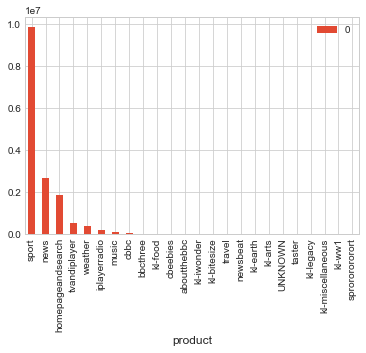

In [11]:
gb_product.plot(kind='bar')

The above graphs shows the BBC products from most popular to least popular, it shows that the sport,news,home page and iplayer are the most popular pages.

In [12]:
# group by source, take the mean of conversion
gb_platform = df.groupby(['platform']).size().sort_values(ascending=False).to_frame()
gb_platform.head()

,0
platform,
Computer,5433941
Tablet,4415217
Mobile,4229074
Unspecified,1716370
Unknown,48113


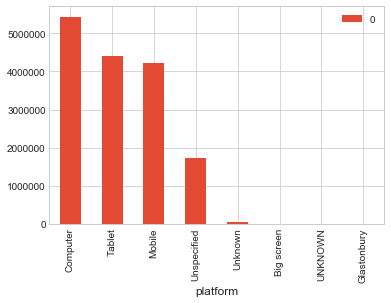

In [13]:
gb_platform.plot(kind='bar')

As expected Computer, Tablet and Mobile are the most popular platforms, they have quite an even split as well.

The first and last day seem to contain incomplete data so won't be much use for training a model. Normally I will drop these days as they will mess up the model and our visualizations.
2016-06-12
2017-03-01 

Next I will briefly look at what the generic data looks like for the period given.

In [30]:
df = df.drop(df[df.date == '2016-06-12'].index)
df = df.drop(df[df.date == '2017-03-01'].index)

In [31]:
pro_df = df.groupby(['date']).size()

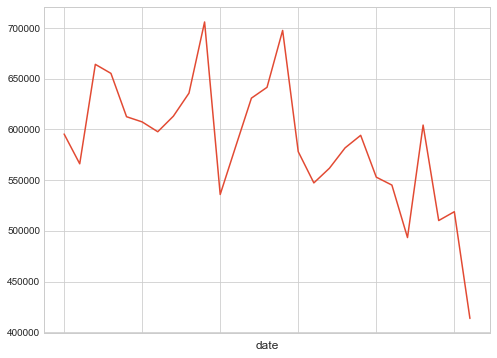

In [32]:
pro_df.plot(kind='line')

The use of BBC products is very erratic and the trend seems to be declining.

## FB Prophet
Next I will use a project by Facebook called FBProphet, A great libarary for forecasting time series data with a particular focus on seasonality. It deals with weekly, monthly and holiday seasonality very well.

Read the paper from Facebook [Here](https://peerj.com/preprints/3190.pdf)

In [33]:
pro_df = pro_df.to_frame().reset_index()

pro_df.columns=['ds', 'y']
pro_df.head()

,ds,y
0,2016-06-13,595442
1,2016-06-14,566104
2,2016-06-15,664133
3,2016-06-16,655219
4,2016-06-17,612507


In [37]:
m = Prophet(daily_seasonality=True, yearly_seasonality=True)
m.fit(pro_df)

future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


,ds,yhat,yhat_lower,yhat_upper
52,2016-08-04,236327.575828,185329.104896,288201.481966
53,2016-08-05,245930.571782,191767.317154,297938.831221
54,2016-08-06,235312.208058,184222.854221,288053.491651
55,2016-08-07,240169.674653,184998.663445,291498.131066
56,2016-08-08,251357.511199,196707.848088,303641.076557


### Prophet General

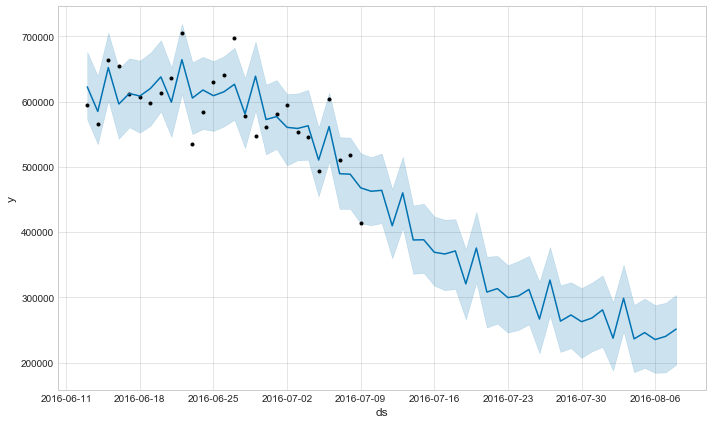

In [38]:
m.plot(forecast);

The above graphs shows the real data over a one month period (The area with the black dots) showing the real data and the right hang side is my prediction for the following 30 days, as we can see we have a declining trend month on month.

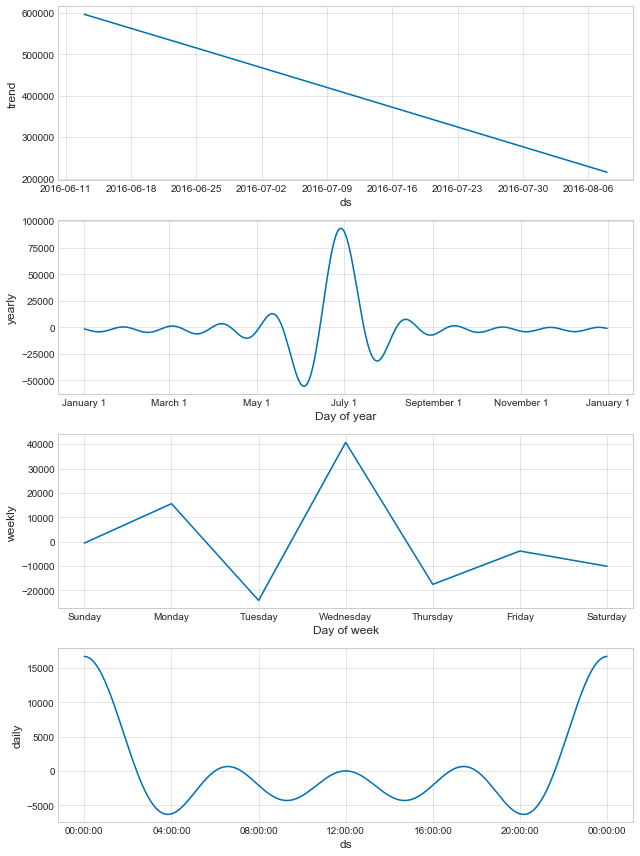

In [39]:
m.plot_components(forecast);

This more advanced plot shows a bit more information as to how the result above was caluculated.

In terms of a general trend at BBC over this period, the trend is that over time we are losing our audience. Our traffic peaks on Wednesday, probably due to some sort of sporting event. We get more traffic on Sunday and Monday as well.
we also get daily traffic spikes at mealtimes and then in the late evening.
This begs a question to me, how do our consumers of different products behave?

### Prophet Grouped By Product

In [41]:
def build_prophet(df, product):
    df = df[df['product'] == product]
    
    gb_df = df.groupby(['date']).size()
    gb_df = gb_df.to_frame().reset_index()
    gb_df.columns=['ds', 'y']

    # build Prophet    
    m = Prophet(daily_seasonality=True, yearly_seasonality=True)
    m.fit(gb_df)

    # Predict 30 days into the future    
    future = m.make_future_dataframe(periods=30)
    forecast = m.predict(future)

    # plot     
    m.plot(forecast);
    m.plot_components(forecast);

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


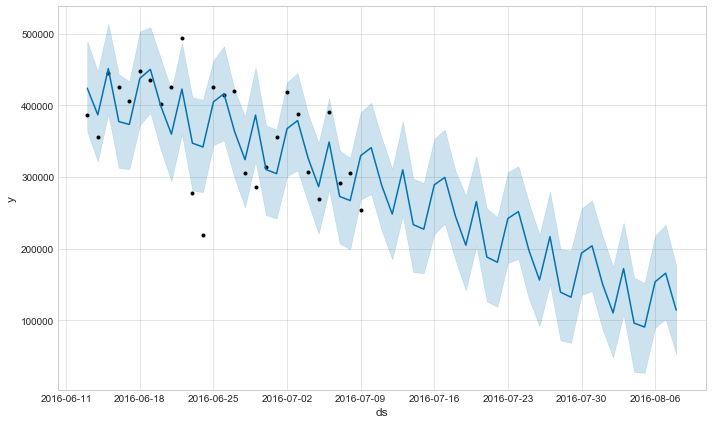

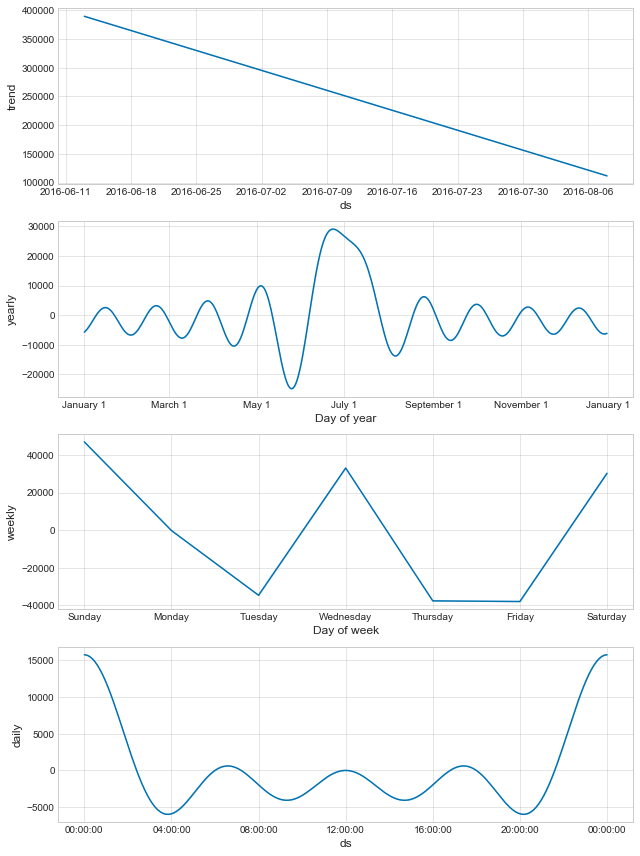

In [42]:
build_prophet(df, 'sport')

We can see that even sports, the most popular of BBC products is experiencing a decline in users. We don't have enough data to infer anything from the yearly seasonality. We can see that Wednesday,Saturday and Sunday bring in the most traffic. I would expect some large sporting event is shown each Wednesday, or even on Tuesday night causing a large uptick in the traffic on Wednesday.
The daily trend shows people checking alongside mealtimes, but also in the evening which is when I imagine most sport events take place.

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


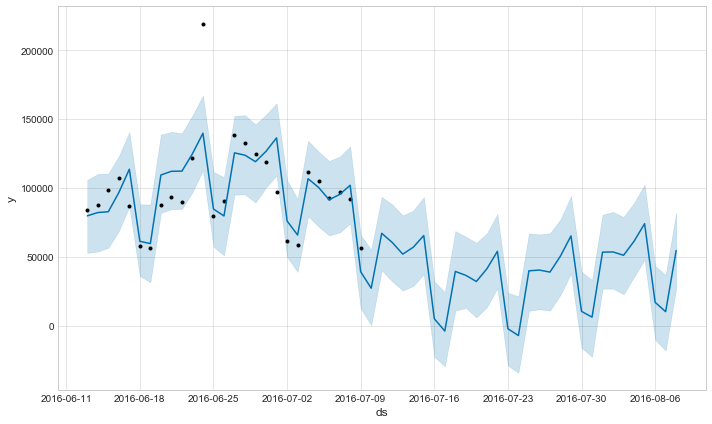

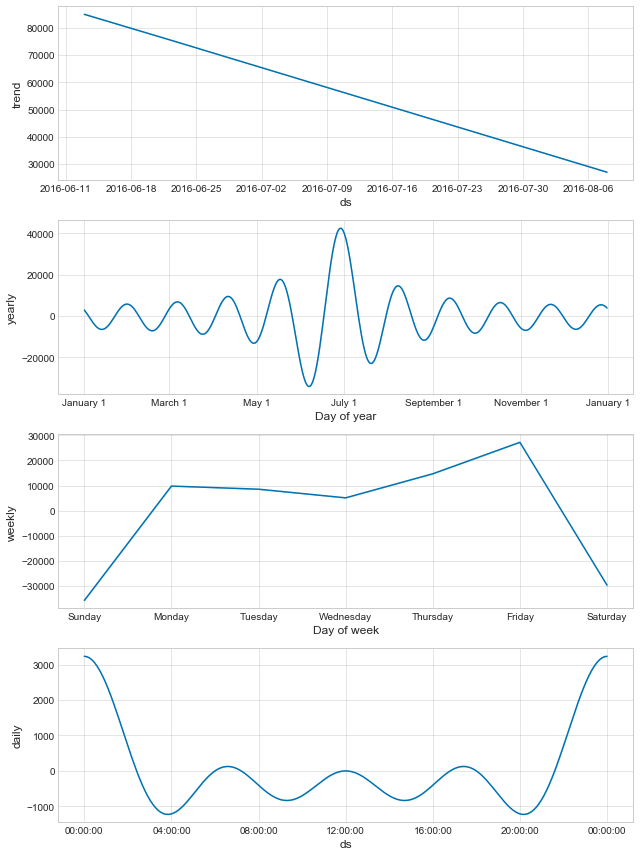

In [43]:
build_prophet(df, 'news')

The news product is checked almost consitently on weekdays, perhaps as an excusable thing to do during work hours that isn't work but looks somewhat relevent/productive. traffic drops on weekends. Similar to the sports product we have peaks around mealtimes and in the evening.

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


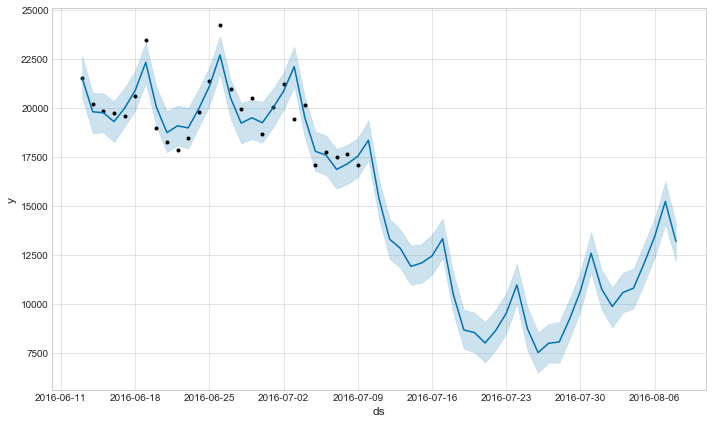

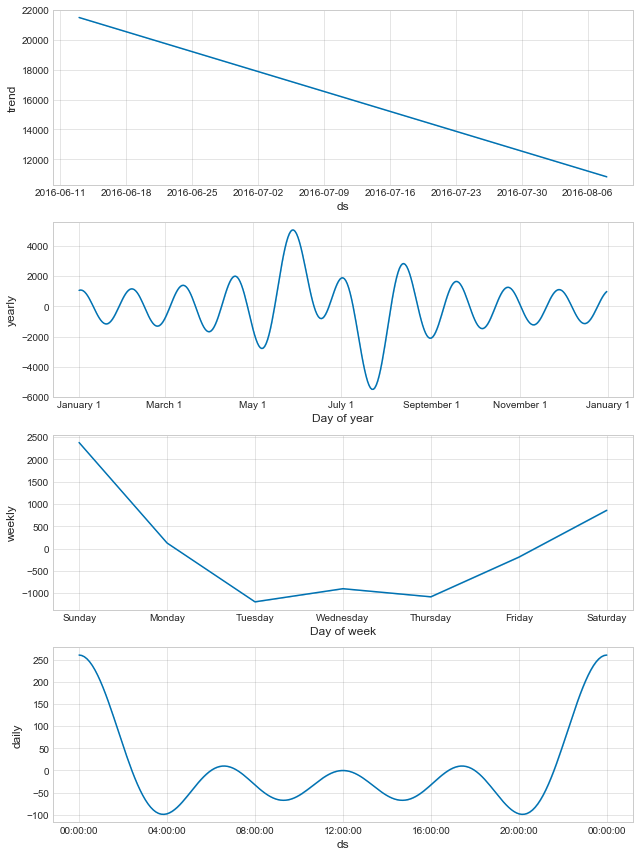

In [44]:
build_prophet(df, 'tvandiplayer')

For TV and iPlayer we have a more leaisurely product, a large increase in use on weekends, and a little peak on Monday. This is as expected. The product is also declining.

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


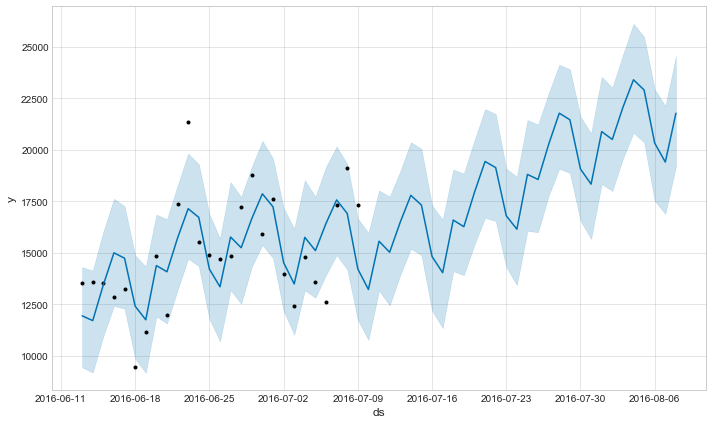

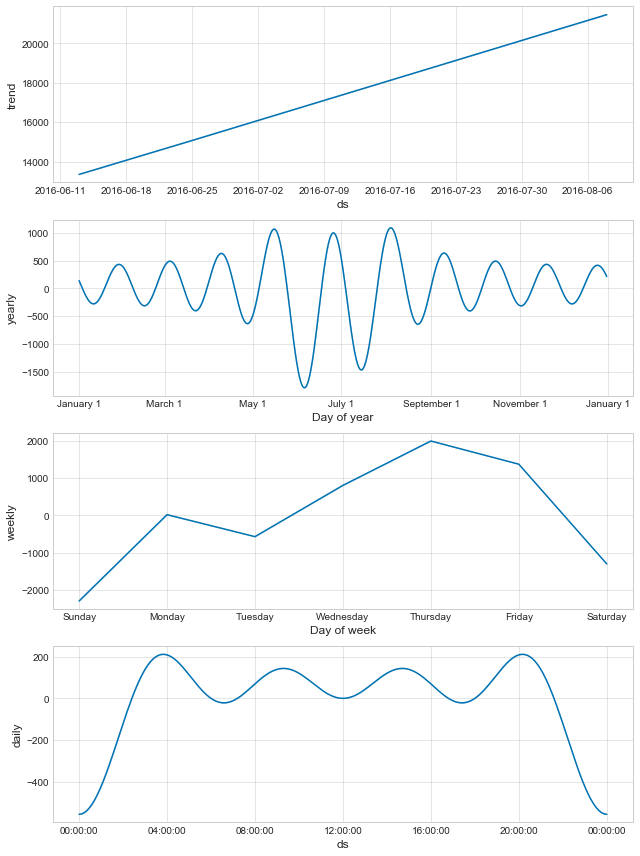

In [45]:
build_prophet(df, 'weather')

Weather, as a welcome change is increasing in use! Usage peaks on A Thursday, perhaps as users are excited to see how the weather will be for the weekend so they know what to plan. Weather is checked consistently over the day.

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


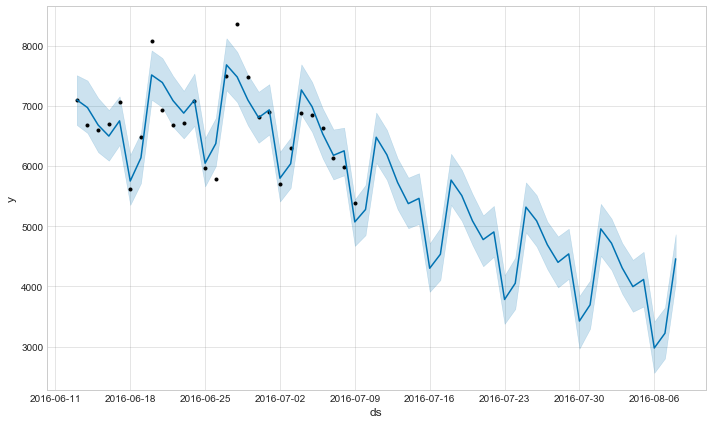

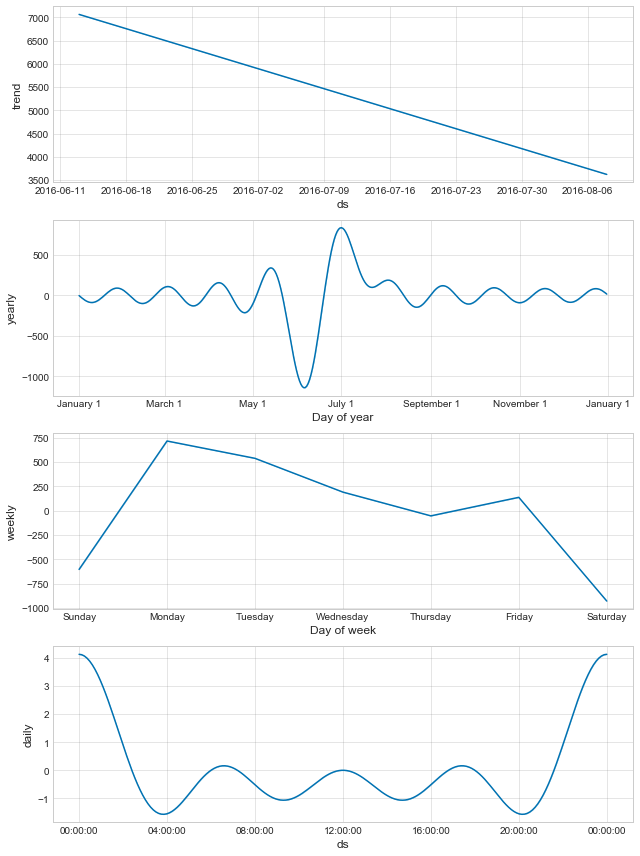

In [46]:
build_prophet(df, 'iplayerradio')

This product is also declining, much like the news this is used a lot more mid-week, perhaps becuase it is easy to casualy listen to. peaking mid week.

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


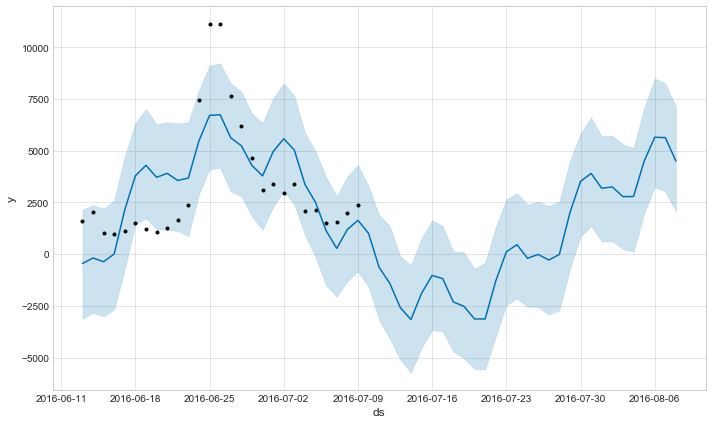

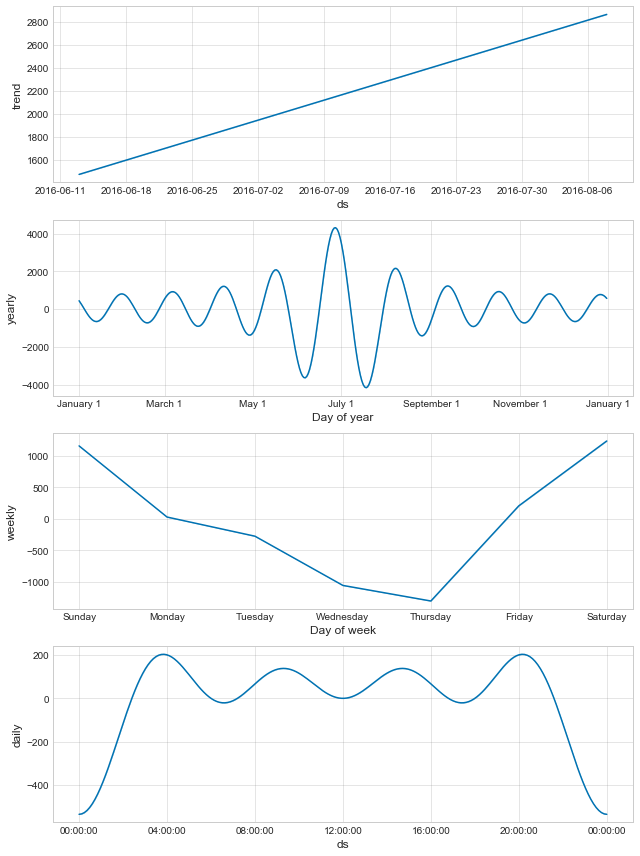

In [47]:
build_prophet(df, 'music')

The Music data is skewed by looking at this short period since Glastonbury occured in the middle of our dataset. This product is still trending upwards but it is difficult to tell the success here. A potential action would be to cover more large festivals if this traffic was worthwhile?

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


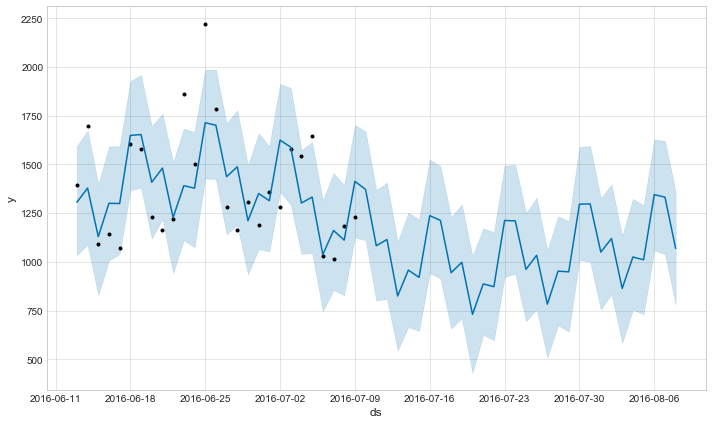

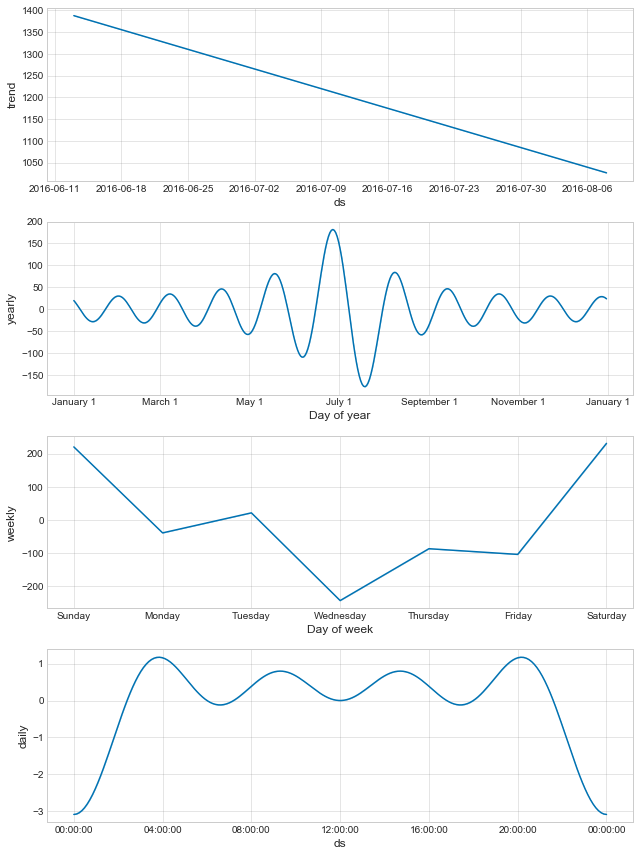

In [48]:
build_prophet(df, 'cbbc')

I would expect cbbc to be a slightly different sort of product, the main user of all other products are most likely adults so this is a whole new segment. Use goes up over the weekend when kids have free time.

### Prophet Grouped By Platform

In [49]:
def build_platform_prophet(df, platform):
    df = df[df['platform'] == platform]
    
    gb_df = df.groupby(['date']).size()
    gb_df = gb_df.to_frame().reset_index()
    gb_df.columns=['ds', 'y']

    # build Prophet    
    m = Prophet(daily_seasonality=True, yearly_seasonality=True)
    m.fit(gb_df)

    # Predict 30 days into the future    
    future = m.make_future_dataframe(periods=30)
    forecast = m.predict(future)

    # plot     
    m.plot(forecast);
    m.plot_components(forecast);

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


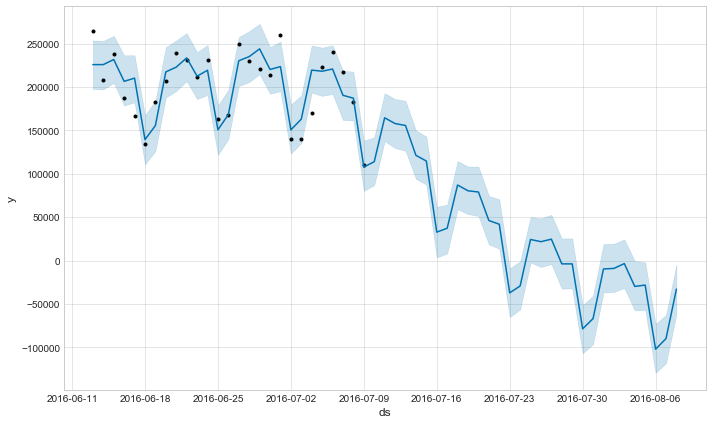

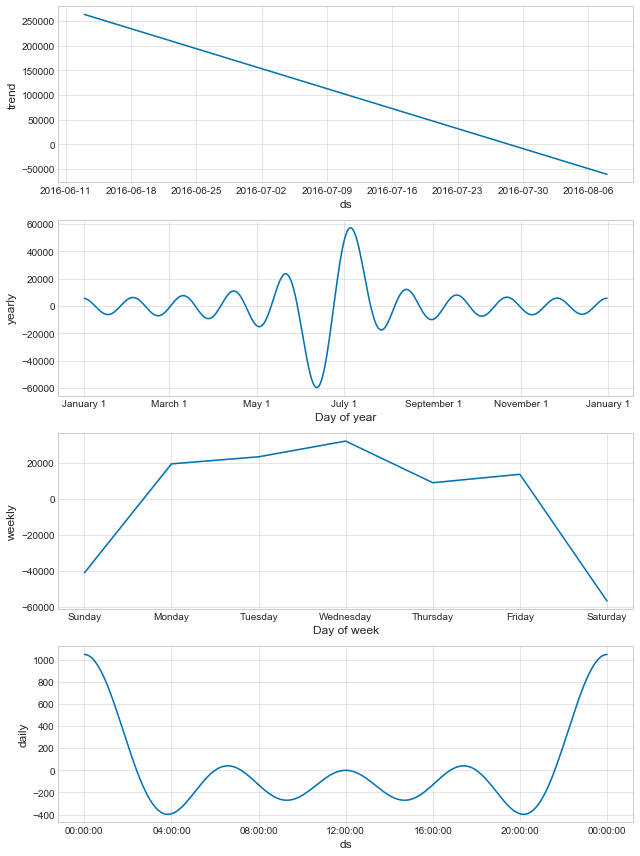

In [50]:
build_platform_prophet(df, 'Computer')

Looking at the users on Computer only is declining as well. Computer users spike mid-week, but drop off over the weekend. This is potentially related to this work-week crowd, users who are utilising the BBC services whilst at work checking the news, listening to music and more.

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


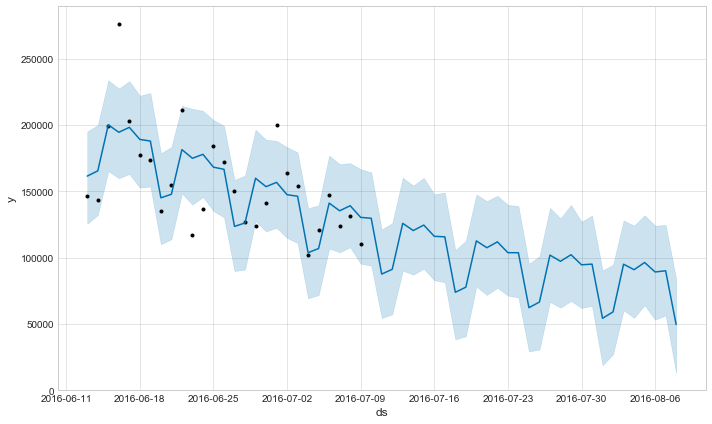

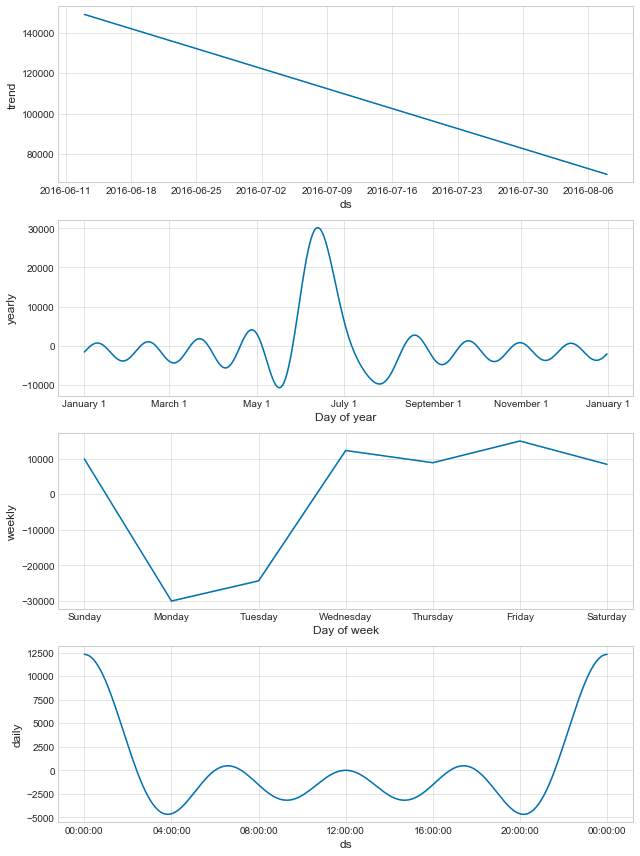

In [51]:
build_platform_prophet(df, 'Mobile')

Mobile usage, whilsts also dropping in number, has a very different footprint. Users drop off on Monday and Tuesday and peak consistently Wednesday to Sunday. I can't explain this drop off on Monday and Tuesday, Perhaps people start their work week trying to be more productive and focused but by Wednesday are getting fatigued and checking their phone more often.

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


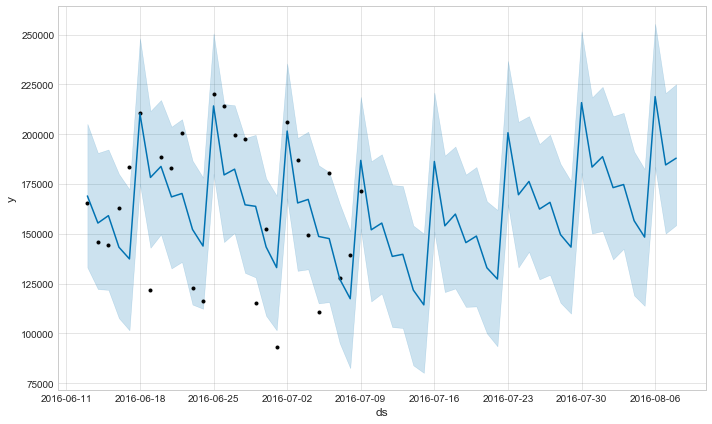

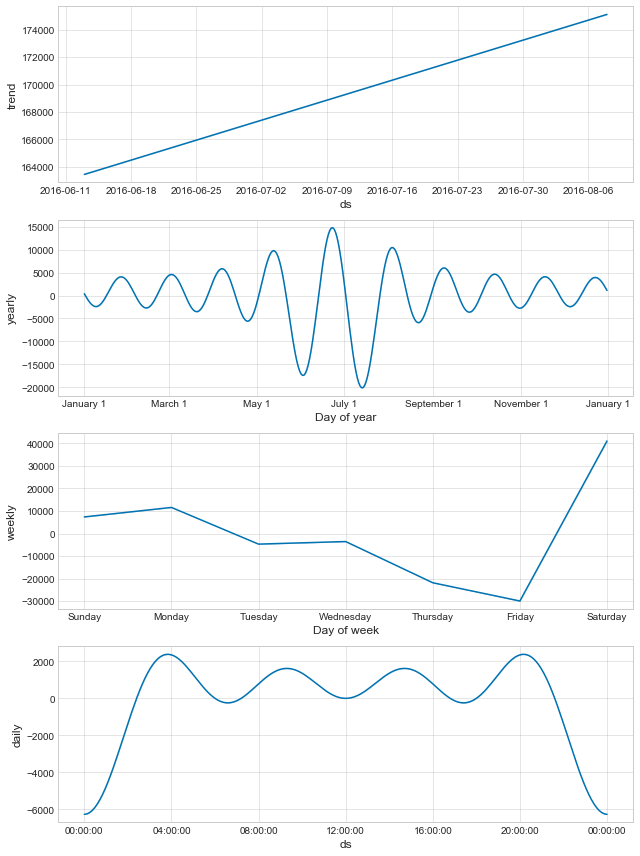

In [52]:
build_platform_prophet(df, 'Tablet')

Tablet data is again very different from Computer and Mobile Data, Tablet users seem to steadily use bbc products less, dropping the most at Friday when people are out, then spiking at Saturday perhaps when people have a lazy weekend day. The nature of tablets is that they are less mobile so it makes sense that they are more tied to a users week.